# Proyecto Final Inteligencia Artificial 2022/23

Alumno: Joan Benlloch Garcia

Profesor: Pedro Concejero Cerezo

Universidad: U-tad

Curso: 3º MAIS A


En este proyecto entrenaremos un modelo de clasificación de imagenes que reconozca distintos tipos de flor. En concreto serán 102 especies de flores distintas, de un dataset de Oxford. El objetivo es conseguir un modelo más preciso que el que hicimos en clase con la clasificación de perrors y gatos. Además de más complejo ya que en ved de diferenciar dos tipos de imágenes únicamente (perros o gatos) estaremos clasificando 102 especies distintas. La idea es simular lo que hace por ejemplo el google lens, en el reconocimiento de flores al hacer una foto.

El dataset que vamos a usar es [este](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)

* La primera parte será, como siempre, preparar el dataset y describirlo, para conocer y entender los datos con los que vamos a trabajar. 
* Lo segundo será diseñar el modelo. Esta es la parte interesante e innovadora del trabajo ya que la capa de entrada será una capa preentrenada para tareas de clasificación de imagen.
* Lo tercero será visualizar graficamente algunos detalles del modelo.
* Por último pondremos a prueba el modelo aplicandolo a nuevas imágenes y visualizando su porcentaje de acierto.

Algunos ejemplos de flores que se encuentran en el dataset son:

<img src='assets/Flowers.png' width=500px>

## Imports

In [2]:

!pip install -q tensorflow-datasets tensorflow
!pip install --upgrade tensorflow-hub


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
#tfds.disable_progress_bar()

C:\Users\joanb\inteligenciaArtificial\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import matplotlib.pyplot as plt
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
import json

## Carga del Dataset

Usando 'tensorflow_datasets' para cargar la base de datos. Esta base de datos esta guardada dentro de los datasets de tensorflow, con el nombre de oxford_flowers102.

Esta base de datos esta dividida en tres conjuntos, el de train, el de test y el de validation. Además tendremos que modificar el tamaño de las imágenes y hacerlas estandar a valores de (255, 255).

In [5]:
data, datainfo = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

#separación de los datos en train, test y validation
test_data = data['test']
train_data = data['train']
val_data =  data['validation']

## Descripción y preparación del Dataset

In [6]:
n_train_examples = len(train_data)
n_test_examples = len(test_data)
n_val_examples = len(val_data)

print("Training examples: ",n_train_examples)
print("Test examples: ",n_test_examples)
print("Validation examples: ",n_val_examples)

n_classes = datainfo.features['label'].num_classes
print("Number of classes: ", n_classes)

Training examples:  1020
Test examples:  6149
Validation examples:  1020
Number of classes:  102


In [7]:
#Aquí podemos ver la forma de las imágenes, distintas entre ellas.
#tendremos que hacer un reshape
im1,im2,im3 = train_data.take(3)
    

print("Image 1 label: ",im1[1].numpy())
print("Image 1 shape: ",im1[0].shape)
print("Image 2 label: ",im2[1].numpy())
print("Image 2 shape: ",im2[0].shape)
print("Image 3 label: ",im3[1].numpy())
print("Image 3 shape: ",im3[0].shape)

Image 1 label:  72
Image 1 shape:  (500, 667, 3)
Image 2 label:  84
Image 2 shape:  (500, 666, 3)
Image 3 label:  70
Image 3 shape:  (670, 500, 3)


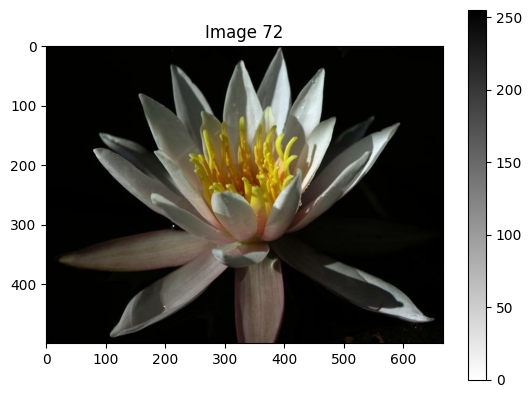

In [8]:
plt.figure()
plt.imshow(im1[0].numpy(), cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.title(str("Image " + str(im1[1].numpy())))
plt.show()

A continuación uso un objeto json para traducir el código de la etiquetas de las flores en el nombre de la especie correspondiente.

In [9]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

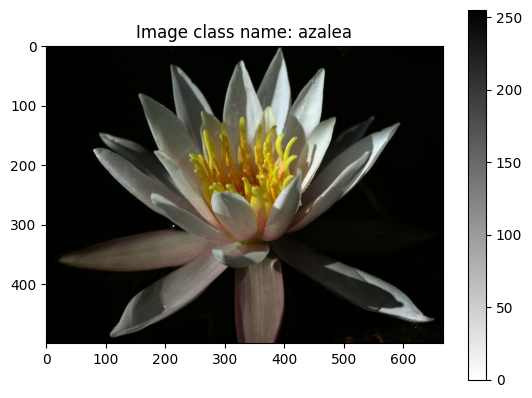

In [10]:
label = im1[1].numpy()

plt.figure()
plt.imshow(im1[0].numpy(), cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.title(str("Image class name: " +  class_names[str(label)] ))
plt.show()

### Pipeline

In [11]:
batch_size = 32
image_size = 224

def format_image(image, label):
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

training_batches = train_data.shuffle(n_train_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = val_data.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_data.map(format_image).batch(batch_size).prefetch(1)

## Diseño y entrenamiento del Modelo

Es importante destacar que vamos a usar el modelo Mobile-Net preentrenado de TensorFlowHub para obtener las características de las imágenes. Este modelo fué entrenado inicialmente en muchos datasets distintos que podemos encontrar [aquí](https://tfhub.dev/s?dataset=imagenet-ilsvrc-2012-cls). Esto va a hacer que tengamos un accuracy mucho mayor que si iniciasemos el modelo desde cero. 

In [12]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))
feature_extractor.trainable = False

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(n_classes, activation = 'softmax')
])

model.summary()




model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
EPOCHS = 20

history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/20
32/32 [==============================] - 34s 971ms/step - loss: 4.3160 - accuracy: 0.1157 - val_loss: 3.1153 - val_accuracy: 0.3578
Epoch 2/20
32/32 [==============================] - 30s 938ms/step - loss: 2.1081 - accuracy: 0.6931 - val_loss: 1.9937 - val_accuracy: 0.6647
Epoch 3/20
32/32 [==============================] - 50s 2s/step - loss: 1.1138 - accuracy: 0.8941 - val_loss: 1.5177 - val_accuracy: 0.7412
Epoch 4/20
32/32 [==============================] - 60s 2s/step - loss: 0.6748 - accuracy: 0.9588 - val_loss: 1.2797 - val_accuracy: 0.7735
Epoch 5/20
32/32 [==============================] - 47s 1s/step - loss: 0.4450 - accuracy: 0.9853 - val_loss: 1.1368 - val_accuracy: 0.7882
Epoch 6/20
32/32 [==============================] - 46s 1s/step - loss: 0.3142 - accuracy: 0.9951 - val_loss: 1.0467 - val_accuracy: 0.7980
Epoch 7/20
32/32 [==============================] - 45s 1s/step - loss: 0.2348 - accuracy: 0.9971 - val_loss: 0.9866 - val_accuracy: 0.8049
Epoch 8/20
32/

Como se puede apreciar, la accuracy del modelo es extremadamente buena, gracias a que usamos un modelo preentrenado. Esto es lo que se busca siempre idealmente, adecuandolo a el trabajo que tengamos que hacer. Conseguir un modelo que haya sido entrenado en una tarea similar a la nuestra y aplicarlo a nuestro proyecto.

### Gráficas
Visualizamos de forma gráfica el acuracy y la loss, en el conjunto de test y el de validation.
Podemos ver como se estanca el acuracy alrededor del 80%, por eso no vale la pena pedirle más épocas. Pero es un resultado bastante bueno.

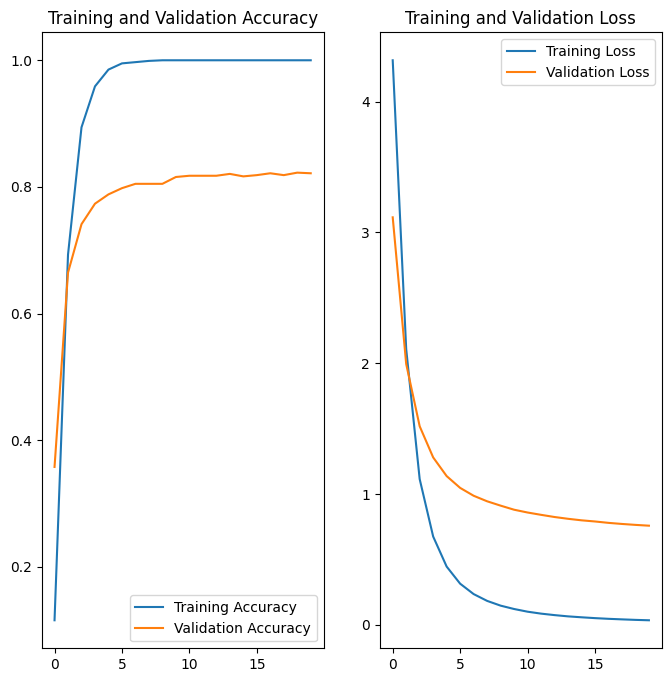

In [14]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Inferencia

A continuación definiremos algunas funciones para estudiar lo bien que funciona el modelo. La idea será conseguir gráficas que muestren de una imagen de una flor cuales son las 5 clases con probabilidad mas alta de ser la flor según el modelo que hemos hecho. 

Para esto lo primero que vamos a hacer es una función que procese la imagen y estandarice el tamaño a (255,255).


In [15]:
def process_image(Image):
    image = np.squeeze(Image)
    image = tf.image.resize(image, (image_size, image_size))/255.0
    return image

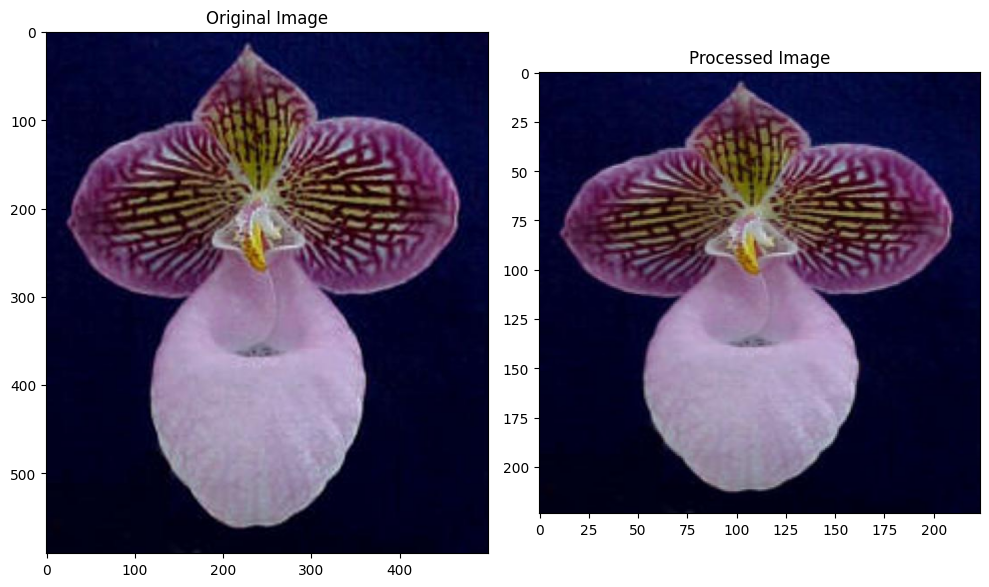

In [16]:
#Puesta a prueba de la función

from PIL import Image
import numpy as np
image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

A la función predict se le pasa una imagen y hace una gráfica con las 5 clases que más probabilida tienen de que la flor de la imagen sea una de ellas

In [17]:
def predict(image_path, model, top_k):
    image = Image.open(image_path)
    numpy_image = np.asarray(image)
    processed_test_image = process_image(numpy_image)

    prediction = model.predict(np.expand_dims(processed_test_image, axis=0))
    top_probs, top_indices = tf.math.top_k(prediction, top_k)
    top_classes = [class_names[str(value+1)] for value in top_indices.cpu().numpy()[0]]  #modified line
    return top_probs,top_classes

### Sanity Check

En la carpeta de test_images hay 7 imágenes en las que vamos a probar esta función. 

In [18]:
cd test_images/

C:\Users\joanb\inteligenciaArtificial\EntregaFinal\test_images


1/1 [==============================] - 0s 54ms/step


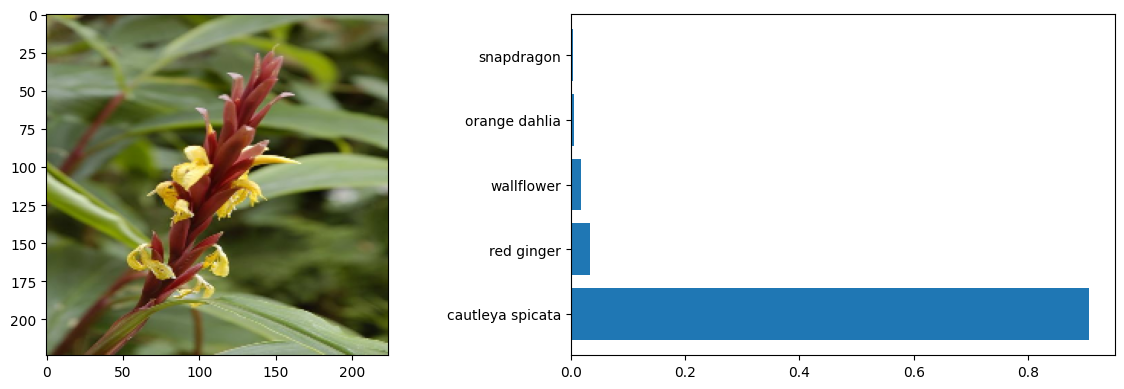

1/1 [==============================] - 0s 50ms/step


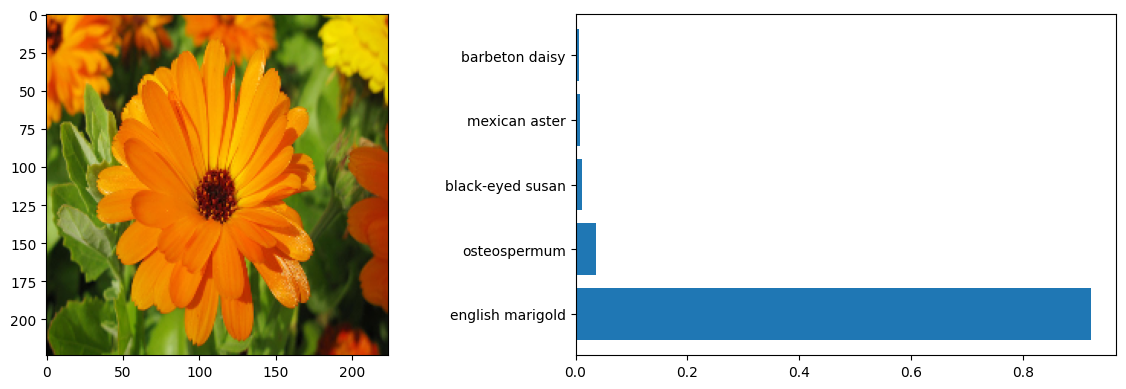

1/1 [==============================] - 0s 48ms/step


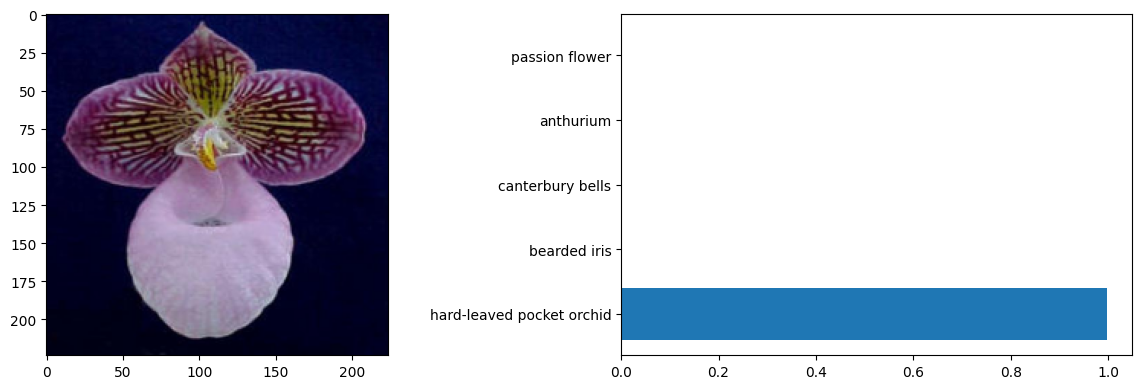

1/1 [==============================] - 0s 52ms/step


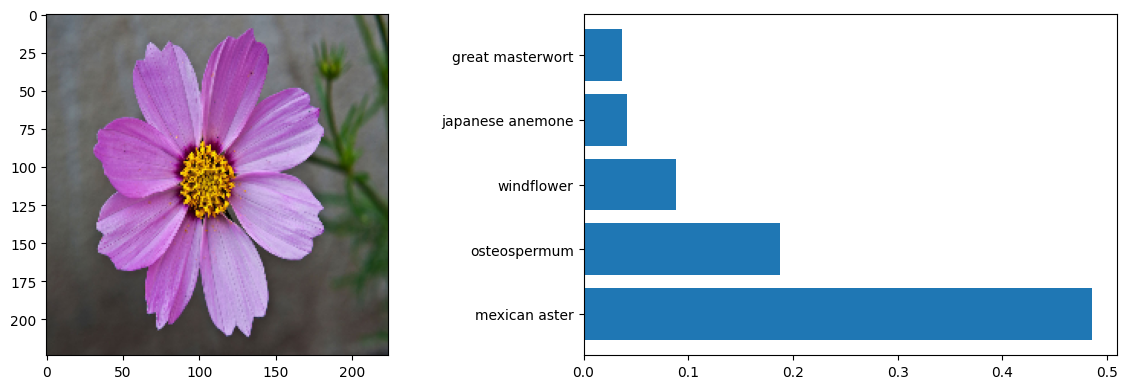

1/1 [==============================] - 0s 54ms/step


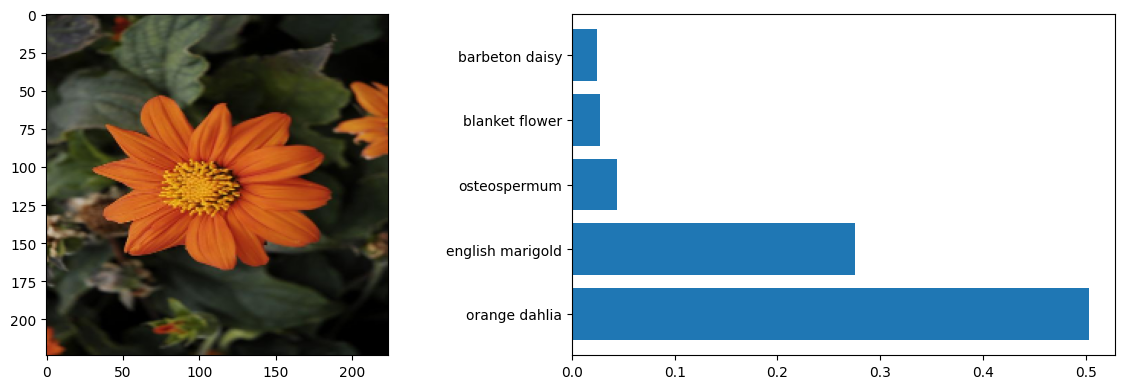

1/1 [==============================] - 0s 56ms/step


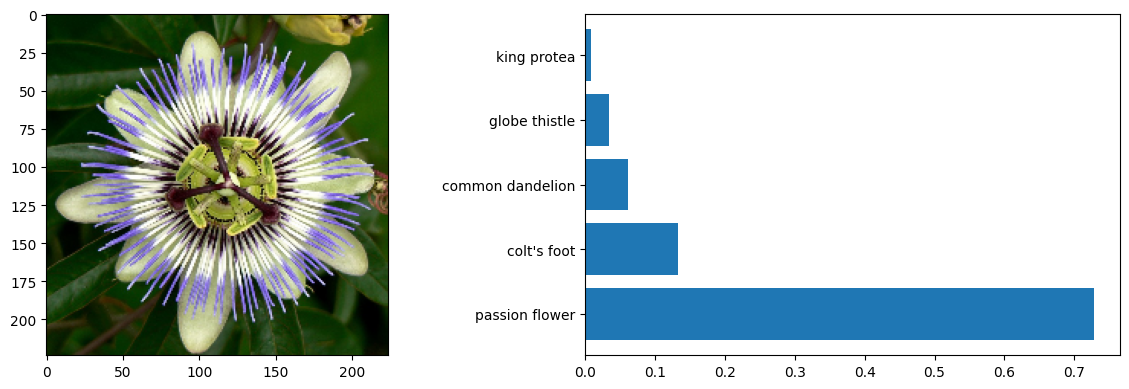

1/1 [==============================] - 0s 50ms/step


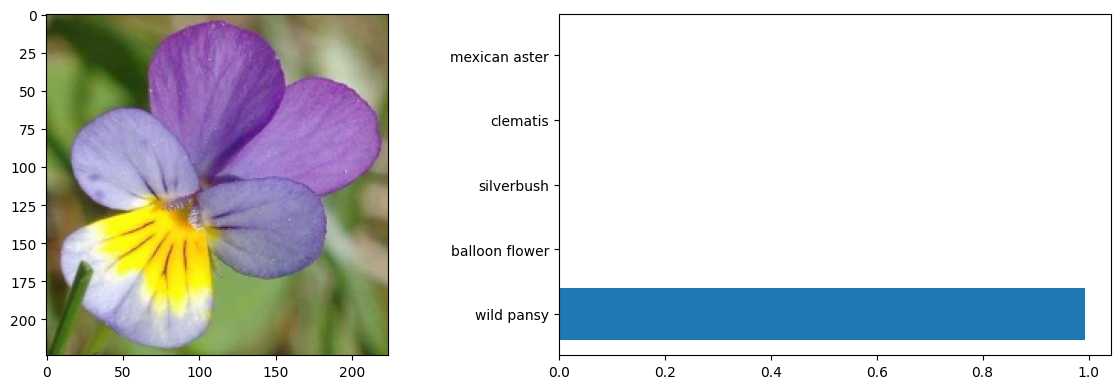

In [20]:
import glob
files = glob.glob('*.jpg')


for image_path in files:
    im = Image.open(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    probs, classes = predict(image_path, model, 5)
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
    ax1.imshow(processed_test_image)

    #print(probs.numpy()[0])
    ax2 = plt.barh(classes, probs.numpy()[0])
    plt.tight_layout()
    plt.show()